# Imports used in the project.

In [105]:
from dataclasses import dataclass, astuple
import os
import pathlib
import base64
from typing import *
import tensorflow as tf
import keras as k

import cv2
import numpy as np
import io
import keras
from PIL import Image
import xmltodict
import pylab as pl

# Data Sets.
- first set : [Playing Cards Labelized Dataset](https://www.kaggle.com/hugopaigneau/playing-cards-dataset).
- second set : [Playing Cards](https://www.kaggle.com/vdntdesai11/playing-cards).

#### Parsing Classes

In [106]:
Paths: Dict[str, str] = {
  'resources': 'resources/',
  'yolo': 'resources/cards/yolo-labeled/',
  'xml': 'resources/cards/xml-labeled/',
  'record': 'resources/cards/combined_record'
}

class FileReader(object):
  @classmethod
  def read(cls, filepath: str) -> bytes:
    with tf.io.gfile.GFile(filepath, 'rb') as file: return file.read()
class ImageReader(FileReader):
  @classmethod
  def encoded_file(cls, imagepath: str) -> bytes:
    raw = super().read(imagepath)
    return base64.b85encode(raw).decode('utf-8')

  @classmethod
  def encoded(cls, image: Image.Image) -> bytes:
    with io.BytesIO() as buffer:
      image.save(buffer, image.format)
      return base64.b85encode(buffer.getvalue())

  @classmethod
  def decoded(cls, imageraw: str) -> Image.Image:
    return Image.open(io.BytesIO(base64.b85decode(imageraw)))

  @classmethod
  def read(cls, imagepath: str) -> Image.Image:
    return Image.open(io.BytesIO(super().read(imagepath)))

  @classmethod
  def read_resized(cls, imagepath: str, size: Tuple[int, int] = (400, 400)) -> Image.Image:
    image = cls.read(imagepath)
    new = image
    new = new.resize(size, Image.ANTIALIAS)
    new.format = image.format
    return new

class FeatureProvider(object):
  @classmethod
  def i64(cls, value) -> tf.train.Feature:
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
  @classmethod
  def i64_list(cls, value) -> tf.train.Feature:
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))
  @classmethod
  def u8(cls, value) -> tf.train.Feature:
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
  @classmethod
  def u8_list(cls, value) -> tf.train.Feature:
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))
  @classmethod
  def f32(cls, value) -> tf.train.Feature:
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
  @classmethod
  def f32_list(cls, value) -> tf.train.Feature:
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))
class RecordProvider(FeatureProvider):
  @classmethod
  def record(cls, features: Dict[str, tf.train.Feature]) -> tf.train.Example:
    return tf.train.Example(features=tf.train.Features(feature=features))

class FeatureWriter(object):
  @staticmethod
  def write(records: Iterable[tf.train.Example], target: str):
    with tf.io.TFRecordWriter(f"{target}.record") as writer:
      for record in records: writer.write(record.SerializeToString())

  @staticmethod
  def combine_write(record_iterators: Iterable[Iterable[tf.train.Example]], target: str, total: int = None):
    with tf.io.TFRecordWriter(f"{target}.record") as writer:
      for (index, record) in enumerate((record for iterator in record_iterators for record in iterator), start=1):
        if (index % 100) == 0: print(f"{index}{f'/{total}' if total else ''} records written.")
        writer.write(record.SerializeToString())

class FeatureReader(object):
  @classmethod
  def read(cls, source: str) -> tf.data.TFRecordDataset:
    return tf.data.TFRecordDataset(f"{source}.record")

## Tensorflow Record preparation

### Parsing records from 'Playing Cards Labelized Dataset' dataset

#### Parse Classes

In [107]:
Classes: Dict[str, str] = {
  'As': 1, 'Ac': 13, 'Ad': 26, 'Ah': 39,
  'Ks': 2, 'Kc': 14, 'Kd': 27, 'Kh': 40,
  'Qs': 3, 'Qc': 15, 'Qd': 28, 'Qh': 41,
  'Js': 4, 'Jc': 16, 'Jd': 29, 'Jh': 42,
  '10s': 5, '10c': 17, '10d': 30, '10h': 43,
  '9s': 6, '9c': 18, '9d': 31, '9h': 44,
  '8s': 7, '8c': 19, '8d': 32, '8h': 45,
  '7s': 8, '7c': 20, '7d': 33, '7h': 46,
  '6s': 9, '6c': 21, '6d': 34, '6h': 47,
  '5s': 10, '5c': 22, '5d': 35, '5h': 48,
  '4s': 11, '4c': 23, '4d': 36, '4h': 49,
  '3s': 12, '3c': 24, '3d': 37, '3h': 50,
  '2s': 25, '2c': 38, '2d': 51, '2h': 52,
}

Xml = Dict[str, Union['Xml', str]]
class XmlReader(FileReader):
  @classmethod
  def read(cls, xmlpath: str) -> Xml:
    return xmltodict.parse(super().read(xmlpath))
class XMlRecordProvider(RecordProvider):
  @classmethod
  def to_record(cls, image: Image.Image, xml: Xml) -> tf.train.Example:
    return cls.record(cls._parse(image, xml))

  @classmethod
  def _parse(cls, image: Image.Image, xml: Xml):
    filename = xml['annotation']['filename']
    (width, height) = map(int, (xml['annotation']['size']['width'], xml['annotation']['size']['height']))
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    texts = []
    labels = []
    for card in xml['annotation']['object']:
      xmins.append(int(card['bndbox']['xmin']) / width)
      xmaxs.append(int(card['bndbox']['xmax']) / width)
      ymins.append(int(card['bndbox']['ymin']) / height)
      ymaxs.append(int(card['bndbox']['ymax']) / height)
      texts.append(card['name'].encode('utf8'))
      labels.append(Classes[card['name']])

    return {
      'name': cls.u8(filename.encode('utf8')),
      'encoded': cls.u8(ImageReader.encoded(image)),
      'format': cls.u8(image.format.encode('utf8')),
      'height': cls.i64(image.height),
      'width': cls.i64(image.width),
      'cards/bbox/xmin': cls.f32_list(xmins),
      'cards/bbox/xmax': cls.f32_list(xmaxs),
      'cards/bbox/ymin': cls.f32_list(ymins),
      'cards/bbox/ymax': cls.f32_list(ymaxs),
      'cards/class/text': cls.u8_list(texts),
      'cards/class/label': cls.i64_list(labels),
    }

#### Parsing process

In [108]:
def xml_pathfinder(extension: str) -> pathlib.Path:
  return pathlib.Path(Paths['xml']).glob(f"*.{extension}")
def xml_record(data: Tuple[Image.Image, Xml]) -> tf.train.Example:
  return XMlRecordProvider.to_record(*data)
def find_xml_record_count():
  return len(list(xml_pathfinder('jpg')))

images = map(ImageReader.read_resized, xml_pathfinder('jpg'))
xmls = map(XmlReader.read, xml_pathfinder('xml'))

xml_count = find_xml_record_count()
xml_records = map(xml_record, zip(images, xmls))

### Parsing records from 'Playing Cards' dataset

#### Parse Classes

In [109]:
@dataclass
class Yolo(object):
  classname: str
  x_center: float
  y_center: float
  width: float
  height: float

  @classmethod
  def from_bbox(cls, bbox: 'BBox') -> 'Yolo':
    (classname, xmin, xmax, ymin, ymax) = astuple(bbox)
    w = xmax - xmin
    h = ymax - ymin
    x = (xmax + xmin) / 2.0
    y = (ymax + ymin) / 2.0
    return cls(classname, x, y, w, h)
@dataclass
class BBox(object):
  classname: str
  xmin: float
  xmax: float
  ymin: float
  ymax: float

  @classmethod
  def from_yolo(cls, yolo: Yolo) -> 'BBox':
    (classname, x_center, y_center, width, height) = astuple(yolo)
    xmax = width / 2 + x_center
    xmin = 2 * x_center - xmax

    ymax = height / 2 + y_center
    ymin = 2 * y_center - ymax
    return cls(classname, xmin, xmax, ymin, ymax)

class YoloReader(FileReader):
  classnames: List[str] = [
    '2c', '3c', '4c', '5c',
    '6c', '7c', '8c', '9c',
    '10c', 'Ac', 'Jc', 'Kc',
    'Qc',
    '2d', '3d', '4d', '5d',
    '6d', '7d', '8d', '9d',
    '10d', 'Ad', 'Jd', 'Kd',
    'Qd',
    '2h', '3h', '4h', '5h',
    '6h', '7h', '8h', '9h',
    '10h', 'Ah', 'Jh', 'Kh',
    'Qh',
    'As', '2s', '3s', '4s',
    '5s', '6s', '7s', '8s',
    '9s', '10s', 'Js', 'Ks',
    'Qs'
  ]

  @classmethod
  def read(cls, yolopath: str) -> Yolo:
    yolos = []
    for yolo_card in super().read(yolopath).decode('utf-8').splitlines():
      (index, *args) = map(float, yolo_card.split())
      yolos.append(Yolo(cls.classnames[int(index)], *args))
    return yolos

class YoloRecordProvider(RecordProvider):
  @classmethod
  def to_record(cls, image: Image.Image, yolos: List[Yolo]) -> tf.train.Example:
    return cls.record(cls._parse(image, yolos))

  @classmethod
  def _parse(cls, image: Image.Image, yolos: List[Yolo]):
    (xmins, xmaxs, ymins, ymaxs) = ([], [], [], [])
    (texts, labels) = ([], [])

    for (classname, xmin, xmax, ymin, ymax) in map(astuple, map(BBox.from_yolo, yolos)):
      texts.append(classname.encode('utf8'))
      labels.append(Classes[classname])
      xmins.append(xmin)
      xmaxs.append(xmax)
      ymins.append(ymin)
      ymaxs.append(ymax)

    return {
      'name': cls.u8('filename'.encode('utf8')),
      'encoded': cls.u8(ImageReader.encoded(image)),
      'format': cls.u8(image.format.encode('utf8')),
      'height': cls.i64(image.height),
      'width': cls.i64(image.width),
      'cards/bbox/xmin': cls.f32_list(xmins),
      'cards/bbox/xmax': cls.f32_list(xmaxs),
      'cards/bbox/ymin': cls.f32_list(ymins),
      'cards/bbox/ymax': cls.f32_list(ymaxs),
      'cards/class/text': cls.u8_list(texts),
      'cards/class/label': cls.i64_list(labels),
    }

#### Parsing Process

In [110]:
def yolo_pathfinder(extension: str) -> pathlib.Path:
  return pathlib.Path(Paths['yolo']).glob(f"*.{extension}")
def yolo_record(data: Tuple[Image.Image, Any]) -> tf.train.Example:
  return YoloRecordProvider.to_record(*data)
def find_yolo_record_count():
  return len(list(yolo_pathfinder('jpg')))

images = map(ImageReader.read_resized, yolo_pathfinder('jpg'))
yolos = map(YoloReader.read, yolo_pathfinder('txt'))

yolo_count = find_yolo_record_count()
yolo_records = map(yolo_record, zip(images, yolos))

## Saving parsed records into record TensorFlow file

In [ ]:
print("Started writing record...")
FeatureWriter.combine_write((xml_records, yolo_records), Paths['record'], total=xml_count + yolo_count)
print("Finished writing record...")

Started writing record...
100/58961 records written.
200/58961 records written.
300/58961 records written.
400/58961 records written.
500/58961 records written.
600/58961 records written.
700/58961 records written.
800/58961 records written.
900/58961 records written.
1000/58961 records written.
1100/58961 records written.
1200/58961 records written.
1300/58961 records written.
1400/58961 records written.
1500/58961 records written.
1600/58961 records written.
1700/58961 records written.
1800/58961 records written.
1900/58961 records written.
2000/58961 records written.
2100/58961 records written.
2200/58961 records written.
2300/58961 records written.
2400/58961 records written.
2500/58961 records written.
2600/58961 records written.
2700/58961 records written.
2800/58961 records written.
2900/58961 records written.
3000/58961 records written.
3100/58961 records written.
3200/58961 records written.
3300/58961 records written.
3400/58961 records written.
3500/58961 records written.
360

## Read records

In [136]:
records = FeatureReader.read(Paths['record'])
record_count = np.sum(1 for _ in records.as_numpy_iterator())

C:\Users\HOUOUI~1\AppData\Local\Temp/ipykernel_20080/2318370469.py:16: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  record_count = np.sum(1 for _ in records.as_numpy_iterator())


### Split into test, validation and training sets

In [140]:
def split_records(records: tf.data.TFRecordDataset,
                  record_count: int,
                  train_split: float = 0.8,
                  test_split: float = 0.1,
                  validation_split: float = 0.1) -> Tuple[
  tf.data.TFRecordDataset, tf.data.TFRecordDataset, tf.data.TFRecordDataset]:
  assert train_split + test_split + validation_split == 1.0
  records = records.shuffle(record_count)
  train_size = int(train_split * record_count)
  val_size = int(validation_split * record_count)

  train = records.take(train_size)
  validation = records.skip(train_size).take(val_size)
  test = records.skip(train_size).skip(val_size)
  return train, test, validation

(train, test, validation) = split_records(records, record_count, 0.8, 0.1, 0.1)

<TakeDataset shapes: (), types: tf.string> <SkipDataset shapes: (), types: tf.string> <TakeDataset shapes: (), types: tf.string>
TensorFlow version: 2.7.0
|> Training set row example <|
|> Test set row example <|
|> Dataset classes <|
{'As': 1, 'Ac': 13, 'Ad': 26, 'Ah': 39, 'Ks': 2, 'Kc': 14, 'Kd': 27, 'Kh': 40, 'Qs': 3, 'Qc': 15, 'Qd': 28, 'Qh': 41, 'Js': 4, 'Jc': 16, 'Jd': 29, 'Jh': 42, '10s': 5, '10c': 17, '10d': 30, '10h': 43, '9s': 6, '9c': 18, '9d': 31, '9h': 44, '8s': 7, '8c': 19, '8d': 32, '8h': 45, '7s': 8, '7c': 20, '7d': 33, '7h': 46, '6s': 9, '6c': 21, '6d': 34, '6h': 47, '5s': 10, '5c': 22, '5d': 35, '5h': 48, '4s': 11, '4c': 23, '4d': 36, '4h': 49, '3s': 12, '3c': 24, '3d': 37, '3h': 50, '2s': 25, '2c': 38, '2d': 51, '2h': 52}
|> Example paths <|


## Read data statistics

In [141]:
train_length = sum(1 for _ in train.as_numpy_iterator())
test_length = sum(1 for _ in test.as_numpy_iterator())
validation_length = sum(1 for _ in validation.as_numpy_iterator())

## Present data statistics

In [153]:
print(f"TensorFlow version: {tf.__version__}")
print()

print(f"|> Training set row example <|")
print(f" - {train_length} records")
print(f" - {train.random()} record")
print()

print(f"|> Test set row example <|")
print(f" - {test_length} records")
print(f" - {test.random()} record")
print()

print(f"|> Validation set row example <|")
print(f" - {validation_length} records")
print(f" - {validation.random()} record")
print()

print(f"|> Dataset classes <|")
print(np.array(list(Classes.keys())))

TensorFlow version: 2.7.0

|> Training set row example <|
 - 47168 records
 - <RandomDataset shapes: (), types: tf.int64> record

|> Test set row example <|
 - 5897 records
 - <RandomDataset shapes: (), types: tf.int64> record

|> Validation set row example <|
 - 5896 records
 - <RandomDataset shapes: (), types: tf.int64> record

|> Dataset classes <|
['As' 'Ac' 'Ad' 'Ah' 'Ks' 'Kc' 'Kd' 'Kh' 'Qs' 'Qc' 'Qd' 'Qh' 'Js' 'Jc'
 'Jd' 'Jh' '10s' '10c' '10d' '10h' '9s' '9c' '9d' '9h' '8s' '8c' '8d' '8h'
 '7s' '7c' '7d' '7h' '6s' '6c' '6d' '6h' '5s' '5c' '5d' '5h' '4s' '4c'
 '4d' '4h' '3s' '3c' '3d' '3h' '2s' '2c' '2d' '2h']



#### Record structure

In [164]:
example = tf.train.Example()
example.ParseFromString(next(iter(train.take(1))).numpy())
print(example)

features {
  feature {
    key: "cards/bbox/xmax"
    value {
      float_list {
        value: 0.5096153616905212
        value: 0.22596153616905212
        value: 0.6850961446762085
        value: 0.8966346383094788
      }
    }
  }
  feature {
    key: "cards/bbox/xmin"
    value {
      float_list {
        value: 0.42067307233810425
        value: 0.13701923191547394
        value: 0.6586538553237915
        value: 0.870192289352417
      }
    }
  }
  feature {
    key: "cards/bbox/ymax"
    value {
      float_list {
        value: 0.14182692766189575
        value: 0.3798076808452606
        value: 0.6177884340286255
        value: 0.9230769276618958
      }
    }
  }
  feature {
    key: "cards/bbox/ymin"
    value {
      float_list {
        value: 0.11057692021131516
        value: 0.3461538553237915
        value: 0.5336538553237915
        value: 0.8341346383094788
      }
    }
  }
  feature {
    key: "cards/class/label"
    value {
      int64_list {
        value: 32

#### Feature Loading

In [173]:
xmins = example.features.feature['cards/bbox/xmin'].float_list.value
xmaxs = example.features.feature['cards/bbox/xmax'].float_list.value
ymins = example.features.feature['cards/bbox/ymin'].float_list.value
ymaxs = example.features.feature['cards/bbox/ymax'].float_list.value
labels = example.features.feature['cards/class/label'].int64_list.value
texts = example.features.feature['cards/class/text'].bytes_list.value
image_raw = example.features.feature['encoded'].bytes_list.value[0]
image_format = example.features.feature['format'].bytes_list.value[0]
image_height = example.features.feature['height'].int64_list.value[0]
image_width = example.features.feature['width'].int64_list.value[0]
name = example.features.feature['name'].bytes_list.value[0]

image = ImageReader.decoded(image_raw)
bboxes = list(map(lambda x: BBox(*x), zip(texts, xmins, xmaxs, ymins, ymaxs)))

#### Feature Presentation - Image

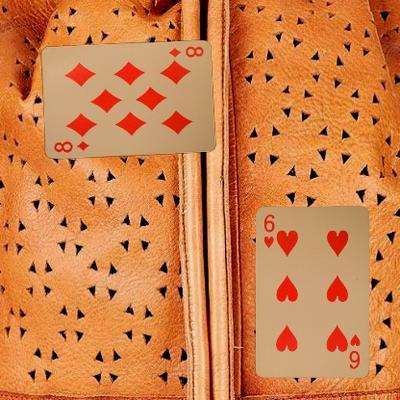

In [174]:
image

#### Feature Presentation - Bounding Boxes

[207  95   9]


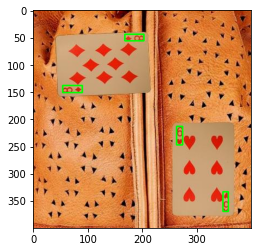

In [175]:
def draw_bboxes(image, bboxes):
  open_cv_image = np.array(image)
  (width, height, _) = open_cv_image.shape
  for (classname, xmin, xmax, ymin, ymax) in map(astuple, bboxes):
    (xmin, xmax, ymin, ymax) = map(int, (xmin * width, xmax * width, ymin * height, ymax * height))
    cv2.rectangle(open_cv_image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
  return open_cv_image
pl.plt.imshow(draw_bboxes(image, bboxes))

# Model.

In [177]:
model: keras.Sequential = keras.Sequential([
  tf.keras.layers.Rescaling(1. / 255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(len(Classes))
])

## Creating.

## Compiling

In [178]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

## Training.

## Validating.

## Wniosking.